This code will separate the files into ABC levels of demand

In [1]:
# load packages
import os
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import random
import datetime
import statsmodels as sm
import sklearn
import sklearn.preprocessing
import sklearn.metrics
import time

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

plt.style.use('ggplot')
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [2]:
# Import Darts and its components
# Darts is a Python library for easy manipulation and forecasting of time series.
# It provides a wide range of models, utilities, and tools for time series analysis.
import darts
from darts import TimeSeries
from darts.utils.utils import generate_index
from darts.metrics import mape, smape, mae, mse, rmse


from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.utils import ModelMode

# import the baseline models
from darts.models import NaiveSeasonal, NaiveMean, ExponentialSmoothing, NaiveMovingAverage, NaiveDrift
# import the statistical models
from darts.models import ARIMA, VARIMA, StatsForecastModel
from darts.models import AutoMFLES, AutoCES, AutoTheta, AutoTBATS, AutoCES, AutoCES, AutoARIMA, Croston
from darts.models import KalmanForecaster, FourTheta, FFT
# import the machine learning models
from darts.models import LightGBMModel, XGBModel, RandomForest, Prophet
# import the deep learning models
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, TFTModel
from darts.models import KalmanFilter
from darts.utils import timeseries_generation as tg

In [3]:
import torch
if torch.backends.mps.is_available():
    torch.set_default_device('cpu')

# Set the default device for PyTorch to CPU
#import torch
#torch.set_default_device('cpu')

In [4]:
# change the working directory to the download directory
os.chdir(os.path.expanduser('~/Downloads/m5-forecasting-accuracy'))
# print the current working directory
print(os.getcwd())

/Users/jimhoover/Downloads/m5-forecasting-accuracy


In [5]:
# read in the CSV file from the M5 competition (30,490 SKUs )
largefile = pd.read_csv('sales_train_evaluation.csv')
# largefile


In [6]:
# report the shape of the largeile dataframe
largefile.shape

(30490, 1947)

In [7]:
# transpose the data frame
transposed_df = largefile.transpose()
transposed_df = transposed_df.reset_index()
transposed_df.head(10)

,index,0,1,2,3,4,5,6,7,8,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
1,item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
2,dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
3,cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
4,store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
5,state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
6,d_1,0,0,0,0,0,0,0,12,2,...,0,14,1,0,4,0,0,0,0,0
7,d_2,0,0,0,0,0,0,0,15,0,...,0,11,1,0,4,0,0,6,0,0
8,d_3,0,0,0,0,0,0,0,0,7,...,0,5,1,0,2,2,0,0,0,0
9,d_4,0,0,0,0,0,0,0,0,3,...,0,6,1,0,5,2,0,2,0,0


In [8]:
# copy the first 6 rows of the transposed_df to a new dataframe called reference_df
reference_df = transposed_df.iloc[:6, :].copy()
reference_df.head(10)



,index,0,1,2,3,4,5,6,7,8,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
1,item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
2,dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
3,cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
4,store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
5,state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI


In [9]:
# delete the first 6 rows of the transposed_df
transposed_df = transposed_df.iloc[6:, :].copy()
# reset the index of the transposed_df
transposed_df = transposed_df.reset_index(drop=True)


In [10]:
transposed_df.head(10)

,index,0,1,2,3,4,5,6,7,8,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,d_1,0,0,0,0,0,0,0,12,2,...,0,14,1,0,4,0,0,0,0,0
1,d_2,0,0,0,0,0,0,0,15,0,...,0,11,1,0,4,0,0,6,0,0
2,d_3,0,0,0,0,0,0,0,0,7,...,0,5,1,0,2,2,0,0,0,0
3,d_4,0,0,0,0,0,0,0,0,3,...,0,6,1,0,5,2,0,2,0,0
4,d_5,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
5,d_6,0,0,0,0,0,0,0,4,2,...,0,13,2,0,7,3,5,4,0,0
6,d_7,0,0,0,0,0,0,0,6,3,...,0,18,1,0,8,1,0,1,0,0
7,d_8,0,0,0,0,0,0,0,5,9,...,0,13,3,0,4,4,1,8,0,0
8,d_9,0,0,0,0,0,0,0,7,0,...,0,18,4,0,4,1,1,5,0,0
9,d_10,0,0,0,0,0,0,0,0,0,...,0,19,1,0,1,0,3,2,0,0


In [11]:
transposed_df.shape

(1941, 30491)

In [12]:
# create new datatime column called date in the transposed_df
transposed_df['date'] = pd.date_range(start='2011-01-29', end='2016-05-22', freq='D')
# set the date column immediately after the first column
transposed_df = transposed_df[['date'] + [col for col in transposed_df.columns if col != 'date']]
transposed_df.head(10)

,date,index,0,1,2,3,4,5,6,7,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,2011-01-29,d_1,0,0,0,0,0,0,0,12,...,0,14,1,0,4,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0,0,0,15,...,0,11,1,0,4,0,0,6,0,0
2,2011-01-31,d_3,0,0,0,0,0,0,0,0,...,0,5,1,0,2,2,0,0,0,0
3,2011-02-01,d_4,0,0,0,0,0,0,0,0,...,0,6,1,0,5,2,0,2,0,0
4,2011-02-02,d_5,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
5,2011-02-03,d_6,0,0,0,0,0,0,0,4,...,0,13,2,0,7,3,5,4,0,0
6,2011-02-04,d_7,0,0,0,0,0,0,0,6,...,0,18,1,0,8,1,0,1,0,0
7,2011-02-05,d_8,0,0,0,0,0,0,0,5,...,0,13,3,0,4,4,1,8,0,0
8,2011-02-06,d_9,0,0,0,0,0,0,0,7,...,0,18,4,0,4,1,1,5,0,0
9,2011-02-07,d_10,0,0,0,0,0,0,0,0,...,0,19,1,0,1,0,3,2,0,0


In [13]:
# change the name of the 'index' column to 'day'
transposed_df.rename(columns={'index': 'day'}, inplace=True)
transposed_df.head(10)

,date,day,0,1,2,3,4,5,6,7,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,2011-01-29,d_1,0,0,0,0,0,0,0,12,...,0,14,1,0,4,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0,0,0,15,...,0,11,1,0,4,0,0,6,0,0
2,2011-01-31,d_3,0,0,0,0,0,0,0,0,...,0,5,1,0,2,2,0,0,0,0
3,2011-02-01,d_4,0,0,0,0,0,0,0,0,...,0,6,1,0,5,2,0,2,0,0
4,2011-02-02,d_5,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
5,2011-02-03,d_6,0,0,0,0,0,0,0,4,...,0,13,2,0,7,3,5,4,0,0
6,2011-02-04,d_7,0,0,0,0,0,0,0,6,...,0,18,1,0,8,1,0,1,0,0
7,2011-02-05,d_8,0,0,0,0,0,0,0,5,...,0,13,3,0,4,4,1,8,0,0
8,2011-02-06,d_9,0,0,0,0,0,0,0,7,...,0,18,4,0,4,1,1,5,0,0
9,2011-02-07,d_10,0,0,0,0,0,0,0,0,...,0,19,1,0,1,0,3,2,0,0


In [14]:
column_names = transposed_df.columns[2:].tolist()
column_names = ['rn_' + str(col) for col in column_names]

In [15]:
# replace the column names except for the date and day columns with the column_names list
transposed_df.columns = ['date', 'day'] + column_names
transposed_df.head(10)

,date,day,rn_0,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,...,rn_30480,rn_30481,rn_30482,rn_30483,rn_30484,rn_30485,rn_30486,rn_30487,rn_30488,rn_30489
0,2011-01-29,d_1,0,0,0,0,0,0,0,12,...,0,14,1,0,4,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0,0,0,15,...,0,11,1,0,4,0,0,6,0,0
2,2011-01-31,d_3,0,0,0,0,0,0,0,0,...,0,5,1,0,2,2,0,0,0,0
3,2011-02-01,d_4,0,0,0,0,0,0,0,0,...,0,6,1,0,5,2,0,2,0,0
4,2011-02-02,d_5,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
5,2011-02-03,d_6,0,0,0,0,0,0,0,4,...,0,13,2,0,7,3,5,4,0,0
6,2011-02-04,d_7,0,0,0,0,0,0,0,6,...,0,18,1,0,8,1,0,1,0,0
7,2011-02-05,d_8,0,0,0,0,0,0,0,5,...,0,13,3,0,4,4,1,8,0,0
8,2011-02-06,d_9,0,0,0,0,0,0,0,7,...,0,18,4,0,4,1,1,5,0,0
9,2011-02-07,d_10,0,0,0,0,0,0,0,0,...,0,19,1,0,1,0,3,2,0,0


In [16]:
# save the transposed_df to a csv file
transposed_df.to_csv('m5_transposed.csv', index=False)


In [17]:
# Convert the date column to proper datetime format
transposed_df['date'] = pd.to_datetime(transposed_df['date'])

evaluation_series = TimeSeries.from_dataframe(
    transposed_df, 
    time_col='date', 
    value_cols=column_names  # Specific columns
)

In [18]:
# create a new dataframe from the transposed_df. Remove the first 2 columns
# the new dataframe should have the remaining column names the same as the column_names list
# the new dataframe should only have one row which is the sum of the values in each column
sum_row = transposed_df[column_names].sum().to_frame().T
sum_row = sum_row.div(1941)
sum_row

,rn_0,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,...,rn_30480,rn_30481,rn_30482,rn_30483,rn_30484,rn_30485,rn_30486,rn_30487,rn_30488,rn_30489
0,0.326121,0.257599,0.159196,1.719217,0.972694,0.861412,0.222566,7.283359,1.178259,0.716641,...,1.242143,2.715611,1.546625,0.65018,3.154044,0.535806,0.375064,0.893354,0.380732,0.702731


In [19]:
# transpose the sum_row dataframe
sum_row = sum_row.transpose()
sum_row = sum_row.reset_index()
# rename the index column to "sku_row"
sum_row.rename(columns={'index': 'sku_row'}, inplace=True)
sum_row


,sku_row,0
0,rn_0,0.326121
1,rn_1,0.257599
2,rn_2,0.159196
3,rn_3,1.719217
4,rn_4,0.972694
...,...,...
30485,rn_30485,0.535806
30486,rn_30486,0.375064
30487,rn_30487,0.893354
30488,rn_30488,0.380732


In [20]:
# change the name of the 2nd column to "daily_sales"
sum_row.rename(columns={sum_row.columns[1]: 'daily_sales'}, inplace=True)

In [21]:
sum_row

,sku_row,daily_sales
0,rn_0,0.326121
1,rn_1,0.257599
2,rn_2,0.159196
3,rn_3,1.719217
4,rn_4,0.972694
...,...,...
30485,rn_30485,0.535806
30486,rn_30486,0.375064
30487,rn_30487,0.893354
30488,rn_30488,0.380732


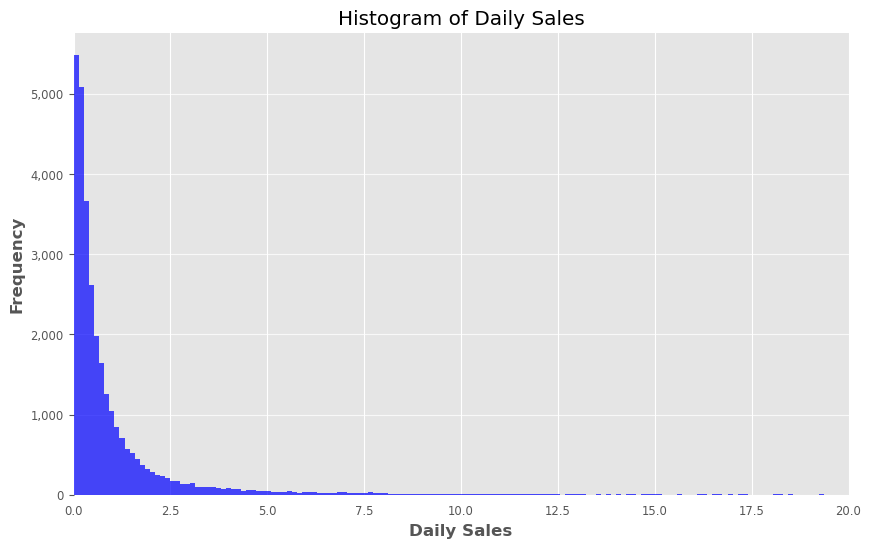

In [41]:
# build a histogram of the daily_sales column in the sum_row dataframe
# limit the x axis from 0 to 20
# increase the number of bins to 50
plt.figure(figsize=(10, 6))
plt.hist(sum_row['daily_sales'], bins=1000, color='blue', alpha=0.7)
# add a comma in the y axis
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
# add a title and labels
plt.title('Histogram of Daily Sales')
plt.xlabel('Daily Sales')
plt.ylabel('Frequency')
plt.xlim(0, 20)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [23]:
# create a new column in the sum_row dataframe to capture the percentile of the daily_sales column
sum_row['percentile'] = sum_row['daily_sales'].rank(pct=True)
sum_row

,sku_row,daily_sales,percentile
0,rn_0,0.326121,0.404788
1,rn_1,0.257599,0.334847
2,rn_2,0.159196,0.210676
3,rn_3,1.719217,0.849278
4,rn_4,0.972694,0.726828
...,...,...,...
30485,rn_30485,0.535806,0.555461
30486,rn_30486,0.375064,0.447163
30487,rn_30487,0.893354,0.704247
30488,rn_30488,0.380732,0.451656


In [24]:
# Create a new column in the sum_row dataframe that categorizes the daily_sales into bins
# the bins should be "A", "B", and "C"
# the percentile cutoffs are:
# A: 0.95 and above
# B: 0.75 to 0.95
# C: below 0.75
def categorize_sales(row):
    if row['percentile'] >= 0.95:
        return 'A'
    elif row['percentile'] >= 0.75:
        return 'B'
    else:
        return 'C'
sum_row['category'] = sum_row.apply(categorize_sales, axis=1)
sum_row

,sku_row,daily_sales,percentile,category
0,rn_0,0.326121,0.404788,C
1,rn_1,0.257599,0.334847,C
2,rn_2,0.159196,0.210676,C
3,rn_3,1.719217,0.849278,B
4,rn_4,0.972694,0.726828,C
...,...,...,...,...
30485,rn_30485,0.535806,0.555461,C
30486,rn_30486,0.375064,0.447163,C
30487,rn_30487,0.893354,0.704247,C
30488,rn_30488,0.380732,0.451656,C


In [25]:
# sumarize the number of SKUs in each category
category_counts = sum_row['category'].value_counts()
category_counts

category
C    22869
B     6096
A     1525
Name: count, dtype: int64

In [26]:
# What is the highest and lowest daily sales in
# each category and calculate the percentage of skus in each category
category_summary = sum_row.groupby('category').agg(
    highest_daily_sales=('daily_sales', 'max'),
    lowest_daily_sales=('daily_sales', 'min'),
    sku_count=('sku_row', 'count')
).reset_index()
category_summary['percentage_of_skus'] = (category_summary['sku_count'] / sum_row['sku_row'].count()) * 100
# round the category_summary percentage_of_skus to 2 decimal places
category_summary['percentage_of_skus'] = category_summary['percentage_of_skus'].round(1)
category_summary    


,category,highest_daily_sales,lowest_daily_sales,sku_count,percentage_of_skus
0,A,130.787738,4.195775,1525,5.0
1,B,4.19526,1.068006,6096,20.0
2,C,1.067491,0.007728,22869,75.0


In [27]:
# save the sum_row dataframe to an Excel file
sum_row.to_excel('m5_sales_summary.xlsx', index=False)

In [28]:
# save the category_summary dataframe to an Excel file
category_summary.to_excel('m5_sales_category_summary.xlsx', index=False)

Illustrate 3 time series - 1 from each ABC category.

In [29]:
# Illustrate the Type A SKU using row 9035.
# Extract the Type A SKU data
df = pd.read_csv('m5_transposed.csv', index_col=False)
# convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])
# df.head(10)
# Extract the column corresponding to SKU 9035 (rn_9035) + date column
# Extract the data for SKU 9035
type_a_sku = df[['date', 'rn_9035']]



In [30]:
type_a_sku

,date,rn_9035
0,2011-01-29,18
1,2011-01-30,17
2,2011-01-31,10
3,2011-02-01,15
4,2011-02-02,7
...,...,...
1936,2016-05-18,35
1937,2016-05-19,19
1938,2016-05-20,26
1939,2016-05-21,19


In [31]:

# split the time series into train and test sets
type_a_series = TimeSeries.from_dataframe(
    type_a_sku, 
    time_col='date', 
    value_cols='rn_9035'
)
train_a, test_a = type_a_series[:-30], type_a_series[-30:]


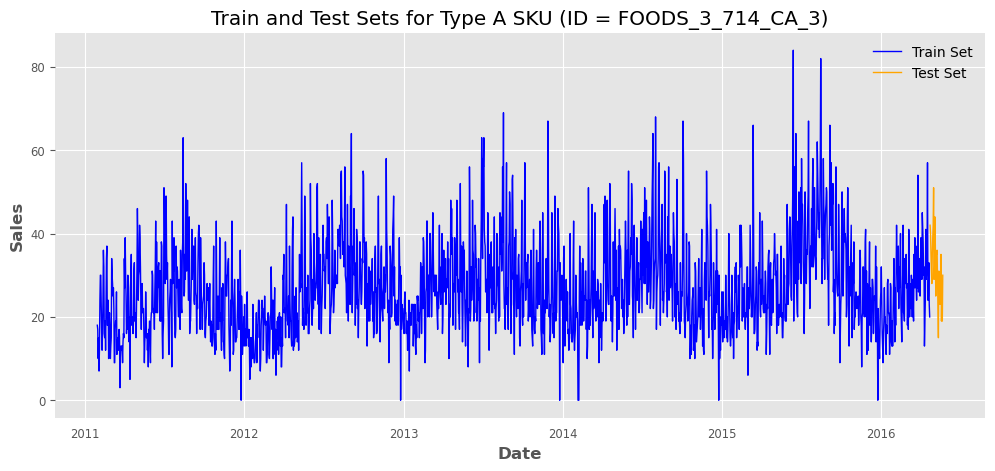

In [48]:
# Plot the time series for Type A SKU
# plot the train and test sets
plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
train_a.plot(label='Train Set', color='blue', linewidth=1)
test_a.plot(label='Test Set', color='orange', linewidth=1)
plt.title('Train and Test Sets for Type A SKU (ID = FOODS_3_714_CA_3)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [33]:
# Illustrate the Type B SKU using row 9033.
# Extract the Type B SKU data
df = pd.read_csv('m5_transposed.csv', index_col=False)
# convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])
# df.head(10)
# Extract the column corresponding to SKU 9033 (rn_9033) + date column
# Extract the data for SKU 9033
type_b_sku = df[['date', 'rn_9033']]

In [34]:
type_b_sku

,date,rn_9033
0,2011-01-29,1
1,2011-01-30,0
2,2011-01-31,2
3,2011-02-01,3
4,2011-02-02,1
...,...,...
1936,2016-05-18,2
1937,2016-05-19,9
1938,2016-05-20,3
1939,2016-05-21,1


In [35]:
# split the time series into train and test sets
type_b_series = TimeSeries.from_dataframe(
    type_b_sku, 
    time_col='date', 
    value_cols='rn_9033'
)
train_b, test_b = type_b_series[:-30], type_b_series[-30:]

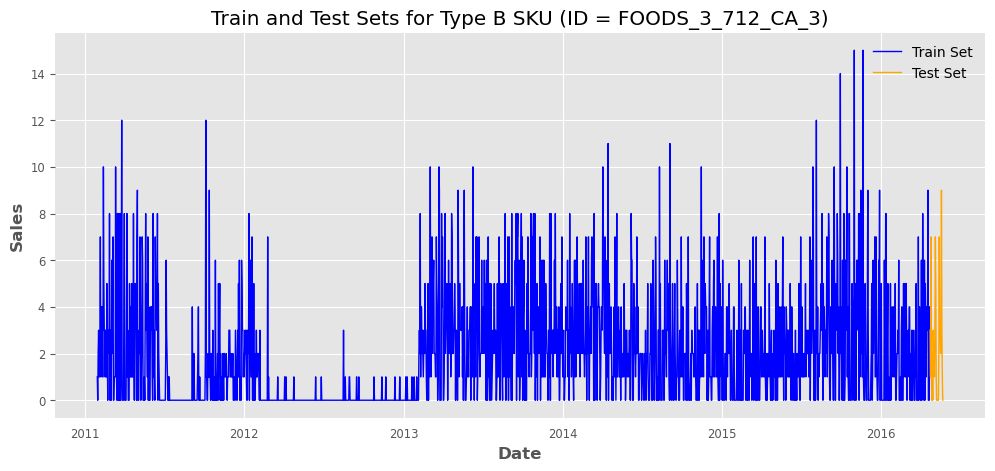

In [47]:
# Plot the time series for Type B SKU
# plot the train and test sets
plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
train_b.plot(label='Train Set', color='blue', linewidth=1)
test_b.plot(label='Test Set', color='orange', linewidth=1)
plt.title('Train and Test Sets for Type B SKU (ID = FOODS_3_712_CA_3)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [37]:
# Illustrate the Type C SKU using row 9057.
# Extract the Type C SKU data
df = pd.read_csv('m5_transposed.csv', index_col=False)
# convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])
# df.head(10)
# Extract the column corresponding to SKU 9043 (rn_9057) + date column
# Extract the data for SKU 9057
type_c_sku = df[['date', 'rn_9057']]

In [38]:
type_c_sku

,date,rn_9057
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0
...,...,...
1936,2016-05-18,1
1937,2016-05-19,0
1938,2016-05-20,1
1939,2016-05-21,0


In [39]:
# split the time series into train and test sets
type_c_series = TimeSeries.from_dataframe(
    type_c_sku, 
    time_col='date', 
    value_cols='rn_9057'
)
train_c, test_c = type_c_series[:-30], type_c_series[-30:]

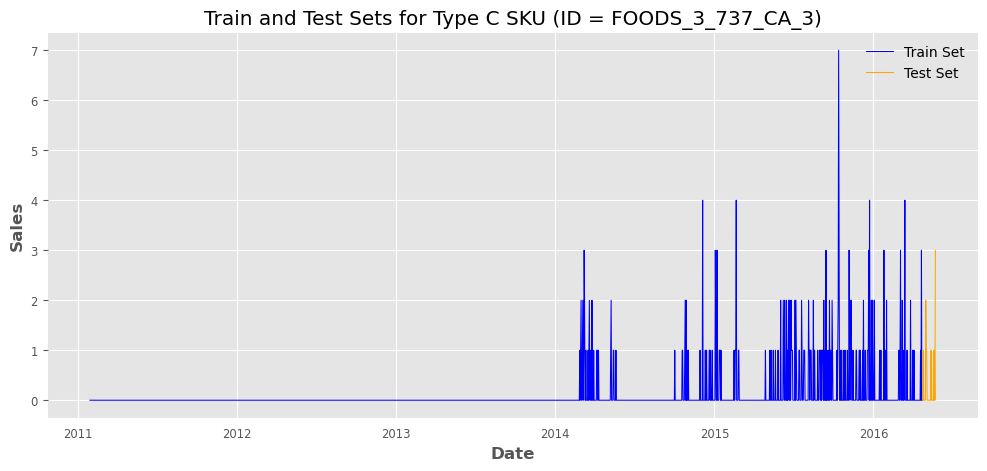

In [51]:
# Plot the time series for Type C SKU
# plot the train and test sets
plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
train_c.plot(label='Train Set', color='blue', linewidth=0.75)
test_c.plot(label='Test Set', color='orange', linewidth=0.75)
plt.title('Train and Test Sets for Type C SKU (ID = FOODS_3_737_CA_3)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

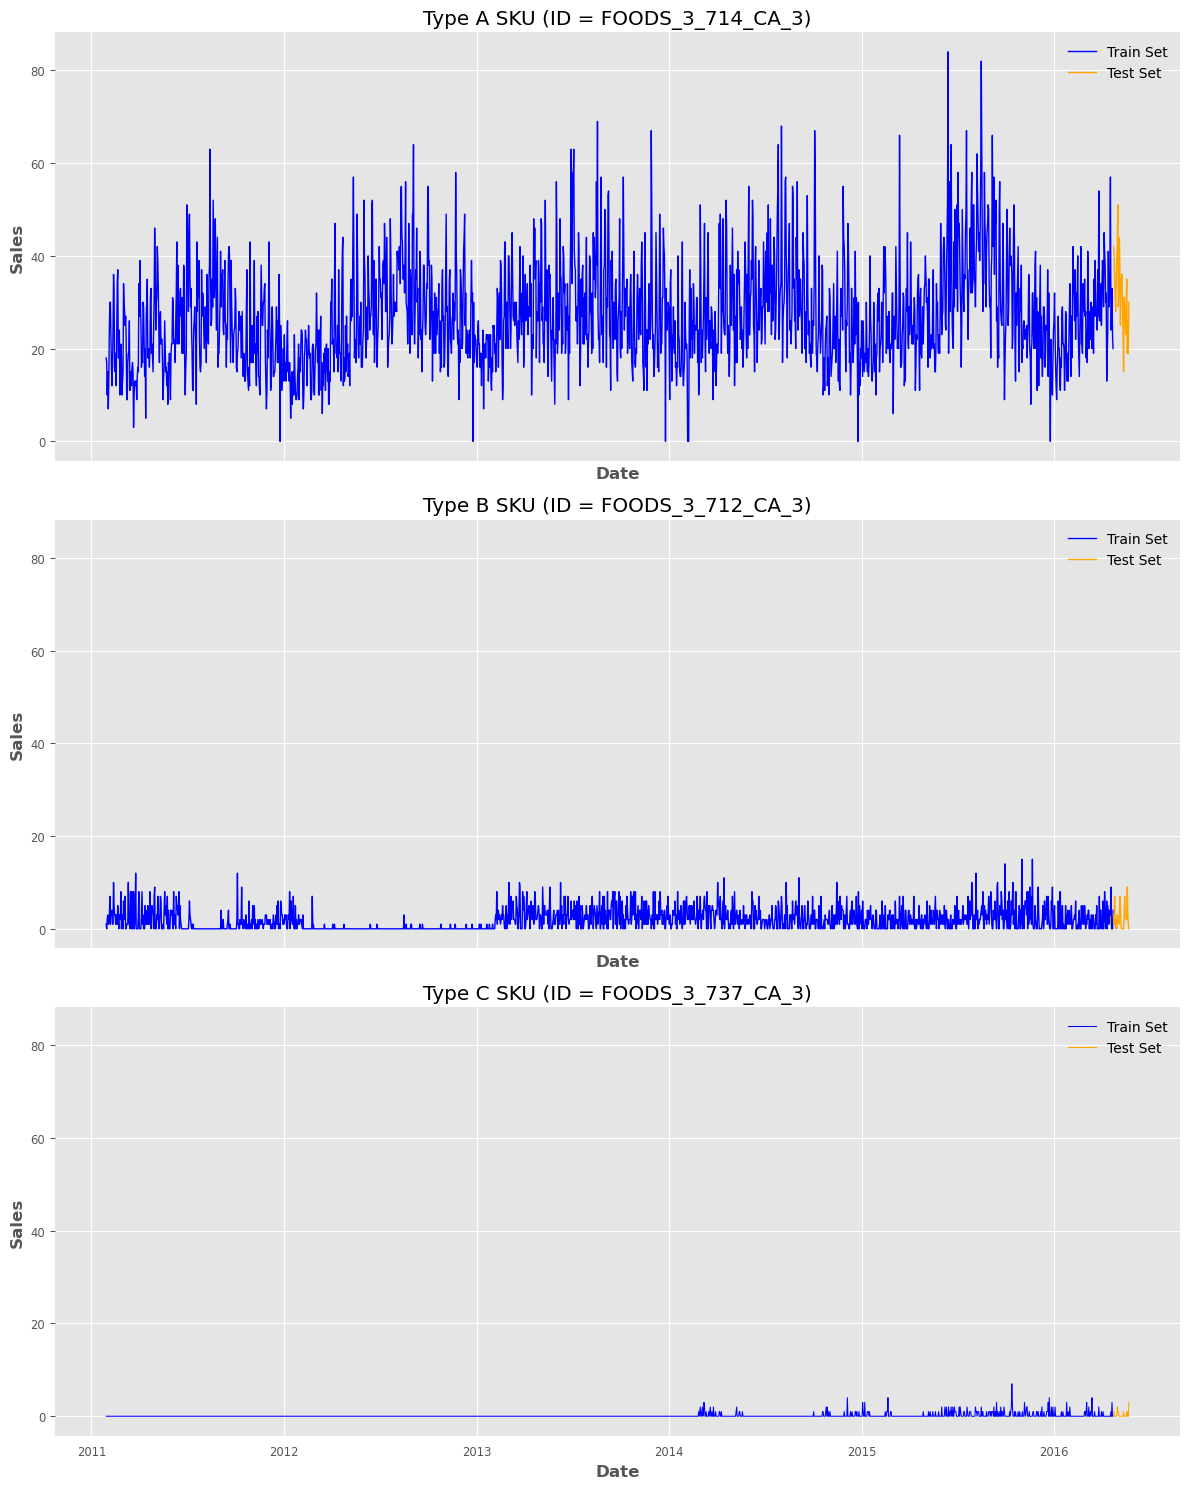

In [52]:
# create all 3 time series plots in a facet grid with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True, sharey=True)
plt.style.use('ggplot')
train_a.plot(ax=axes[0], label='Train Set', color='blue', linewidth=1)
test_a.plot(ax=axes[0], label='Test Set', color='orange', linewidth=1)
axes[0].set_title('Type A SKU (ID = FOODS_3_714_CA_3)')
axes[0].set_ylabel('Sales')
axes[0].set_xlabel('Date')
axes[0].legend()
train_b.plot(ax=axes[1], label='Train Set', color='blue', linewidth=1)
test_b.plot(ax=axes[1], label='Test Set', color='orange', linewidth=1)
axes[1].set_title('Type B SKU (ID = FOODS_3_712_CA_3)')
axes[1].set_ylabel('Sales')
axes[1].set_xlabel('Date')
axes[1].legend()
train_c.plot(ax=axes[2], label='Train Set', color='blue', linewidth=0.75)
test_c.plot(ax=axes[2], label='Test Set', color='orange', linewidth=0.75)
axes[2].set_title('Type C SKU (ID = FOODS_3_737_CA_3)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')
axes[2].legend()
plt.tight_layout()
plt.show()